In [1]:
import yfinance as yf
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Set default seaborn figure size
sns.axes_style(rc={'figure.figsize': (10, 5)})


# ==== Marcos
BTC_ETF = "IBIT"

# =====
# Fetch [SYMBOL] data with a 1-minute interval
SYMBOLS = ["BTC-USD", BTC_ETF]
df = yf.download(SYMBOLS, interval="1m", period="5d")
df.dropna(inplace=True)
df.reset_index(inplace=True)


df['Date'] = df['Datetime'].dt.date

df['dt'] = df['Datetime'].diff().dt.total_seconds() / 60
df[['BTC-USD_LR', 'IBIT_LR']] = df['Close'].map(np.log).diff()

df['dt_clean'] = df['dt'] == 1
df = df.fillna(df.iloc[1])
df.head()


[*********************100%***********************]  2 of 2 completed


Price                   Datetime          Close                      High  \
Ticker                                  BTC-USD       IBIT        BTC-USD   
0      2025-01-07 14:30:00+00:00  100748.257812  57.244999  100748.257812   
1      2025-01-07 14:31:00+00:00  100588.125000  57.310001  100588.125000   
2      2025-01-07 14:33:00+00:00  100677.382812  57.254101  100677.382812   
3      2025-01-07 14:35:00+00:00  100374.570312  57.128799  100374.570312   
4      2025-01-07 14:36:00+00:00  100459.132812  57.055000  100459.132812   

Price                        Low                      Open             \
Ticker       IBIT        BTC-USD       IBIT        BTC-USD       IBIT   
0       57.349998  100748.257812  57.215000  100748.257812  57.320999   
1       57.340000  100588.125000  57.220001  100588.125000  57.240002   
2       57.301201  100677.382812  57.240002  100677.382812  57.301201   
3       57.219299  100374.570312  57.070000  100374.570312  57.110001   
4       57.160000  100459.132812  57.035000  100459.132812  57.130001   

Price      Volume                   Date   dt BTC-USD_LR   IBIT_LR dt_clean  
Ticker    BTC-USD       IBIT                                                 
0             0.0  2613141.0  2025-01-07  1.0  -0.001591  0.001135    False  
1       3264512.0    98381.0  2025-01-07  1.0  -0.001591  0.001135     True  
2       7806976.0   116226.0  2025-01-07  2.0   0.000887 -0.000976    False  
3             0.0   210402.0  2025-01-07  2.0  -0.003012 -0.002191    False  
4             0.0   105420.0  2025-01-07  1.0   0.000842 -0.001293     True

In [451]:
df.groupby('dt').count()

/var/folders/c8/c3xvsb_56wq1czrwq0kr796c0000gn/T/ipykernel_73253/438279646.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.groupby('dt').count()


Price  Datetime   Close         High          Low         Open       Volume  \
Ticker          BTC-USD IBIT BTC-USD IBIT BTC-USD IBIT BTC-USD IBIT BTC-USD   
dt                                                                            
1.0         551     551  551     551  551     551  551     551  551     551   
2.0         278     278  278     278  278     278  278     278  278     278   
3.0          20      20   20      20   20      20   20      20   20      20   
1051.0        1       1    1       1    1       1    1       1    1       1   
2492.0        1       1    1       1    1       1    1       1    1       1   

Price       Date BTC-USD_LR IBIT_LR dt_clean  
Ticker IBIT                                   
dt                                            
1.0     551  551        551     551      551  
2.0     278  278        278     278      278  
3.0      20   20         20      20       20  
1051.0    1    1          1       1        1  
2492.0    1    1          1       1        1

In [452]:
LR_match = {'t_crypto':[], 't_etf':[], 't+1_crypto':[], 't+1_etf':[], 'Datetime':[]}    

for i in range(1, df.shape[0]):
    valid = df['dt_clean'].iloc[i]
    if valid == False:
        continue
    else:
        LR_match['t_crypto'].append(df['BTC-USD_LR'].iloc[i-1])
        LR_match['t_etf'].append(df['IBIT_LR'].iloc[i-1])
        LR_match['t+1_crypto'].append(df['BTC-USD_LR'].iloc[i])
        LR_match['t+1_etf'].append(df['IBIT_LR'].iloc[i])
        LR_match['Datetime'].append(df['Datetime'].iloc[i])

LR_match = pd.DataFrame(LR_match)

LR_match['sync'] = LR_match['t_crypto'] * LR_match['t_etf']
LR_match['balance'] = LR_match['t_crypto'] * LR_match['t+1_etf']
LR_match = LR_match.iloc[1:]

<Axes: >

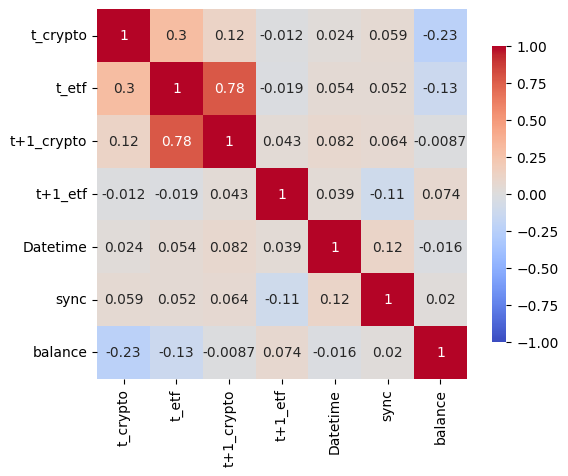

In [453]:
sns.heatmap(LR_match.corr(), annot=True, cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, vmax=1, vmin=-1)

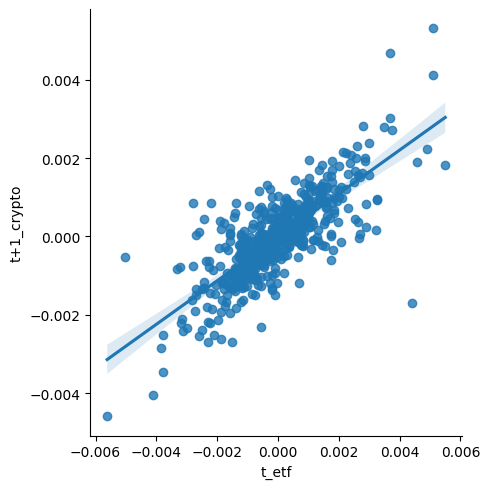

In [454]:
sns.lmplot(LR_match, x='t_etf', y='t+1_crypto')

<Axes: ylabel='Count'>

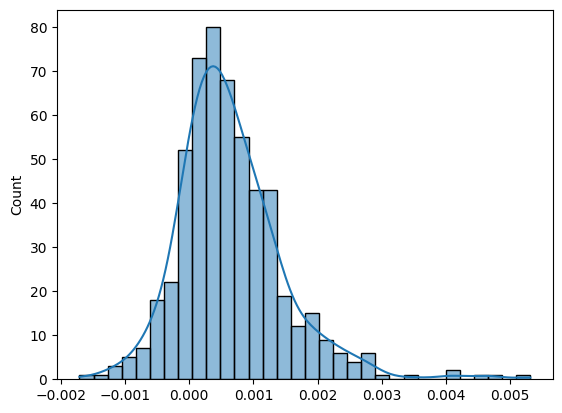

In [455]:
s = 1
delta = s * 1

LR_match['pos'] = np.where(LR_match['t_etf'] < 0, -delta, delta)
# LR_match['t+1_crypto'] * 

sns.histplot(LR_match['pos'] * LR_match['t+1_crypto'], kde=True)

<Axes: >

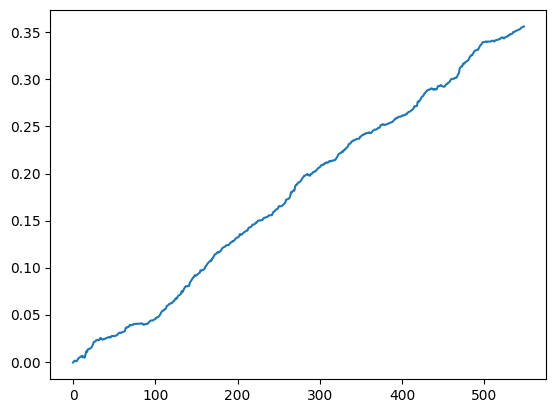

In [458]:
(df[df['Datetime'].isin(LR_match['Datetime'])]['BTC-USD_LR'].reset_index(drop='index') * LR_match.reset_index()['pos']).cumsum()